In [1]:
from src.simulator import Simulator
from src.parameters import ModelParameters, MPCParameters
from src.controller import MPC, LinearReferenceMPC, LQR
from src.plotter import Plotter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import threading
import tikzplotlib
from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']

In [3]:
m1 = 0.5
m2 = 0.5
L1 = 0.5
L2 = 0.5
l2 = 0.5*L2
l1 = 0.5*L1
I1 = m1*l1**2
I2 = m2*l2**2
f1 = 0.01
f2 = 0.01

model_params_sim = ModelParameters

model_params_sim.m1 = m1
model_params_sim.m2 = m2
model_params_sim.L1 = L1
model_params_sim.L2 = L2
model_params_sim.l1 = l2
model_params_sim.l2 = l1
model_params_sim.I1 = I1
model_params_sim.I2 = I2
model_params_sim.f1 = f1
model_params_sim.f2 = f2

In [4]:
sim = Simulator(dt=0.01)
sim.set_model_params(model_parameters=model_params_sim)

In [5]:
mpc_params = MPCParameters

mpc_params.N = 50
mpc_params.dt = 0.01
mpc_params.u_lim = 4
mpc_params.max_iter = 100

mpc = MPC()
mpc.set_controller_params(controller_parameters=mpc_params)
mpc.set_model_params(model_parameters=model_params_sim)

lin_mpc = LinearReferenceMPC()
lin_mpc.set_controller_params(controller_parameters=mpc_params)
lin_mpc.set_model_params(model_parameters=model_params_sim)

Q = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])*1
R = np.array([1])

lqr = LQR()
lqr.set_model_params(model_parameters=model_params_sim)
lqr.set_controller_params(Q=Q, R=R)
K = lqr.get_K()
coordinate_diff = np.array([np.pi,0,0,0])

print(K)

[[15.53300648 15.27053819  4.51680817  1.91790733]]


In [27]:
steps = 400
ulim = 4

def simulate(x0=[3, 0.5, 0, 0]):
  x_sim_mpc = np.ndarray((steps, 4))
  x_sim_lin_mpc = np.ndarray((steps, 4))
  x_sim_lqr = np.ndarray((steps, 4))

  x_sim_mpc[0] = x0
  x_sim_lin_mpc[0] = x0
  x_sim_lqr[0] = x0

  for i in tqdm(range(steps-1)):

    model, feas, xOpt, uOpt, JOpt = mpc.solve_cftoc(x_sim_mpc[i])
    u_mpc = uOpt[0,0]

    modell, feasl, xOptl, uOptl, JOptl = lin_mpc.solve_cftoc(x_sim_lin_mpc[i])
    u_lin_mpc = uOptl[0,0]

    u_lqr = K @ (x_sim_lqr[i]-coordinate_diff)
    if u_lqr > ulim: u_lqr = ulim
    elif u_lqr < -ulim: u_lqr = -ulim

    x_sim_mpc[i+1] = sim.simulate_step(x=x_sim_mpc[i], u=u_mpc)
    x_sim_lin_mpc[i+1] = sim.simulate_step(x=x_sim_lin_mpc[i], u=u_lin_mpc)
    x_sim_lqr[i+1] = sim.simulate_step(x=x_sim_lqr[i], u=u_lqr)
  
  return x_sim_mpc, x_sim_lin_mpc, x_sim_lqr


In [29]:
x0_values = [
  [3, 0.5, 0, 0],
  [2.8, 0.5, 0, 0],
  [2.6, 0.5, 0, 0]
]

x_sim_mpc_results = []
x_sim_lin_mpc_results = []
x_sim_lqr_results = []

for x0 in x0_values:
  x_sim_mpc, x_sim_lin_mpc, x_sim_lqr = simulate(x0)

  x_sim_mpc_results.append(x_sim_mpc)
  x_sim_lin_mpc_results.append(x_sim_lin_mpc)
  x_sim_lqr_results.append(x_sim_lqr)

100%|██████████| 399/399 [01:48<00:00,  3.69it/s]


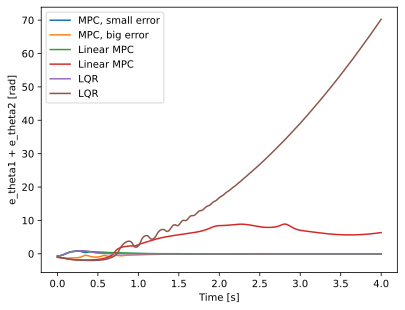

In [36]:
steps = 400
dt = 0.01
time = np.linspace(0, steps*dt, num=steps)

# plt.plot(time, x_sim_mpc[:,0]-np.pi-x_sim_mpc[:,1], label="MPC")
# plt.plot(time, x_sim_lin_mpc[:,0]-np.pi-x_sim_lin_mpc[:,1], label="Linear MPC")
# plt.plot(time, x_sim_lqr[:,0]-np.pi-x_sim_lqr[:,1], label="LQR")

plt.plot(time, x_sim_mpc_results[0][:,0]-np.pi-x_sim_mpc_results[0][:,1], label="MPC, small error")
# plt.plot(time, x_sim_mpc_results[2][:,0]-np.pi-x_sim_mpc_results[2][:,1], label="MPC, big error")
plt.plot(time, x_sim_lin_mpc_results[0][:,0]-np.pi-x_sim_lin_mpc_results[0][:,1], label="Linear MPC")
# plt.plot(time, x_sim_lin_mpc_results[2][:,0]-np.pi-x_sim_lin_mpc_results[2][:,1], label="Linear MPC")
plt.plot(time, x_sim_lqr_results[0][:,0]-np.pi-x_sim_lqr_results[0][:,1], label="LQR")
# plt.plot(time, x_sim_lqr_results[2][:,0]-np.pi-x_sim_lqr_results[2][:,1], label="LQR")

plt.xlabel('Time [s]')
plt.ylabel('e_theta1 + e_theta2 [rad]')
plt.legend()
plt.show()

In [11]:
plotter = Plotter
anim = plotter.animate_pendulum(x_sim_mpc[:,0], x_sim_mpc[:,1], model_params_sim.L1, model_params_sim.L2, dt=0.01)
anim